In [1]:
# !pip install torchmetrics

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import torch
torch.manual_seed(0)
np.random.seed(0)
import torch.nn as nn
from torch.autograd import Variable
import torchmetrics as metrics
from torch.utils.data import Dataset, DataLoader,  TensorDataset
import torch.optim as optim

import matplotlib.gridspec as gridspec
# Set the Seaborn context to 'talk' and style to 'whitegrid'
sns.set_context('talk')
sns.set_style('white')

In [3]:
# Read Excel file
excel_file = '../../../data/raw/weeklydata.xlsx'
df = pd.read_excel(excel_file, engine='openpyxl')

In [4]:
# View data and column headings
print("Excel Data:")
print(df)
print("\nColumn Headings:")
print(df.columns)

Excel Data:
       state  year             datetime  epiweek  cases   tempmaxw   tempminw  \
0     Bauchi  2018  2018-01-07 00:00:00        1    1.0  29.500000  10.800000   
1     Bauchi  2018  2018-01-14 00:00:00        2    0.0  27.600000  10.800000   
2     Bauchi  2018  2018-01-21 00:00:00        3    0.0  30.500000  11.700000   
3     Bauchi  2018  2018-01-28 00:00:00        4    0.0  28.500000  13.100000   
4     Bauchi  2018  2018-02-04 00:00:00        5    0.0  34.600000  15.600000   
...      ...   ...                  ...      ...    ...        ...        ...   
1090    Ondo  2024             Week1091       48    8.0  34.442857  20.800000   
1091    Ondo  2024             Week1092       49   15.0  34.528571  21.328571   
1092    Ondo  2024             Week1093       50   16.0  34.671429  20.228571   
1093    Ondo  2024             Week1094       51   13.0  34.414286  18.657143   
1094    Ondo  2024             Week1095       52   28.0  34.914286  19.528571   

          tempw

C:\Users\Yaknan\AppData\Local\Temp\ipykernel_25072\925444792.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\Yaknan\AppData\Local\Temp\ipykernel_25072\925444792.py:18: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


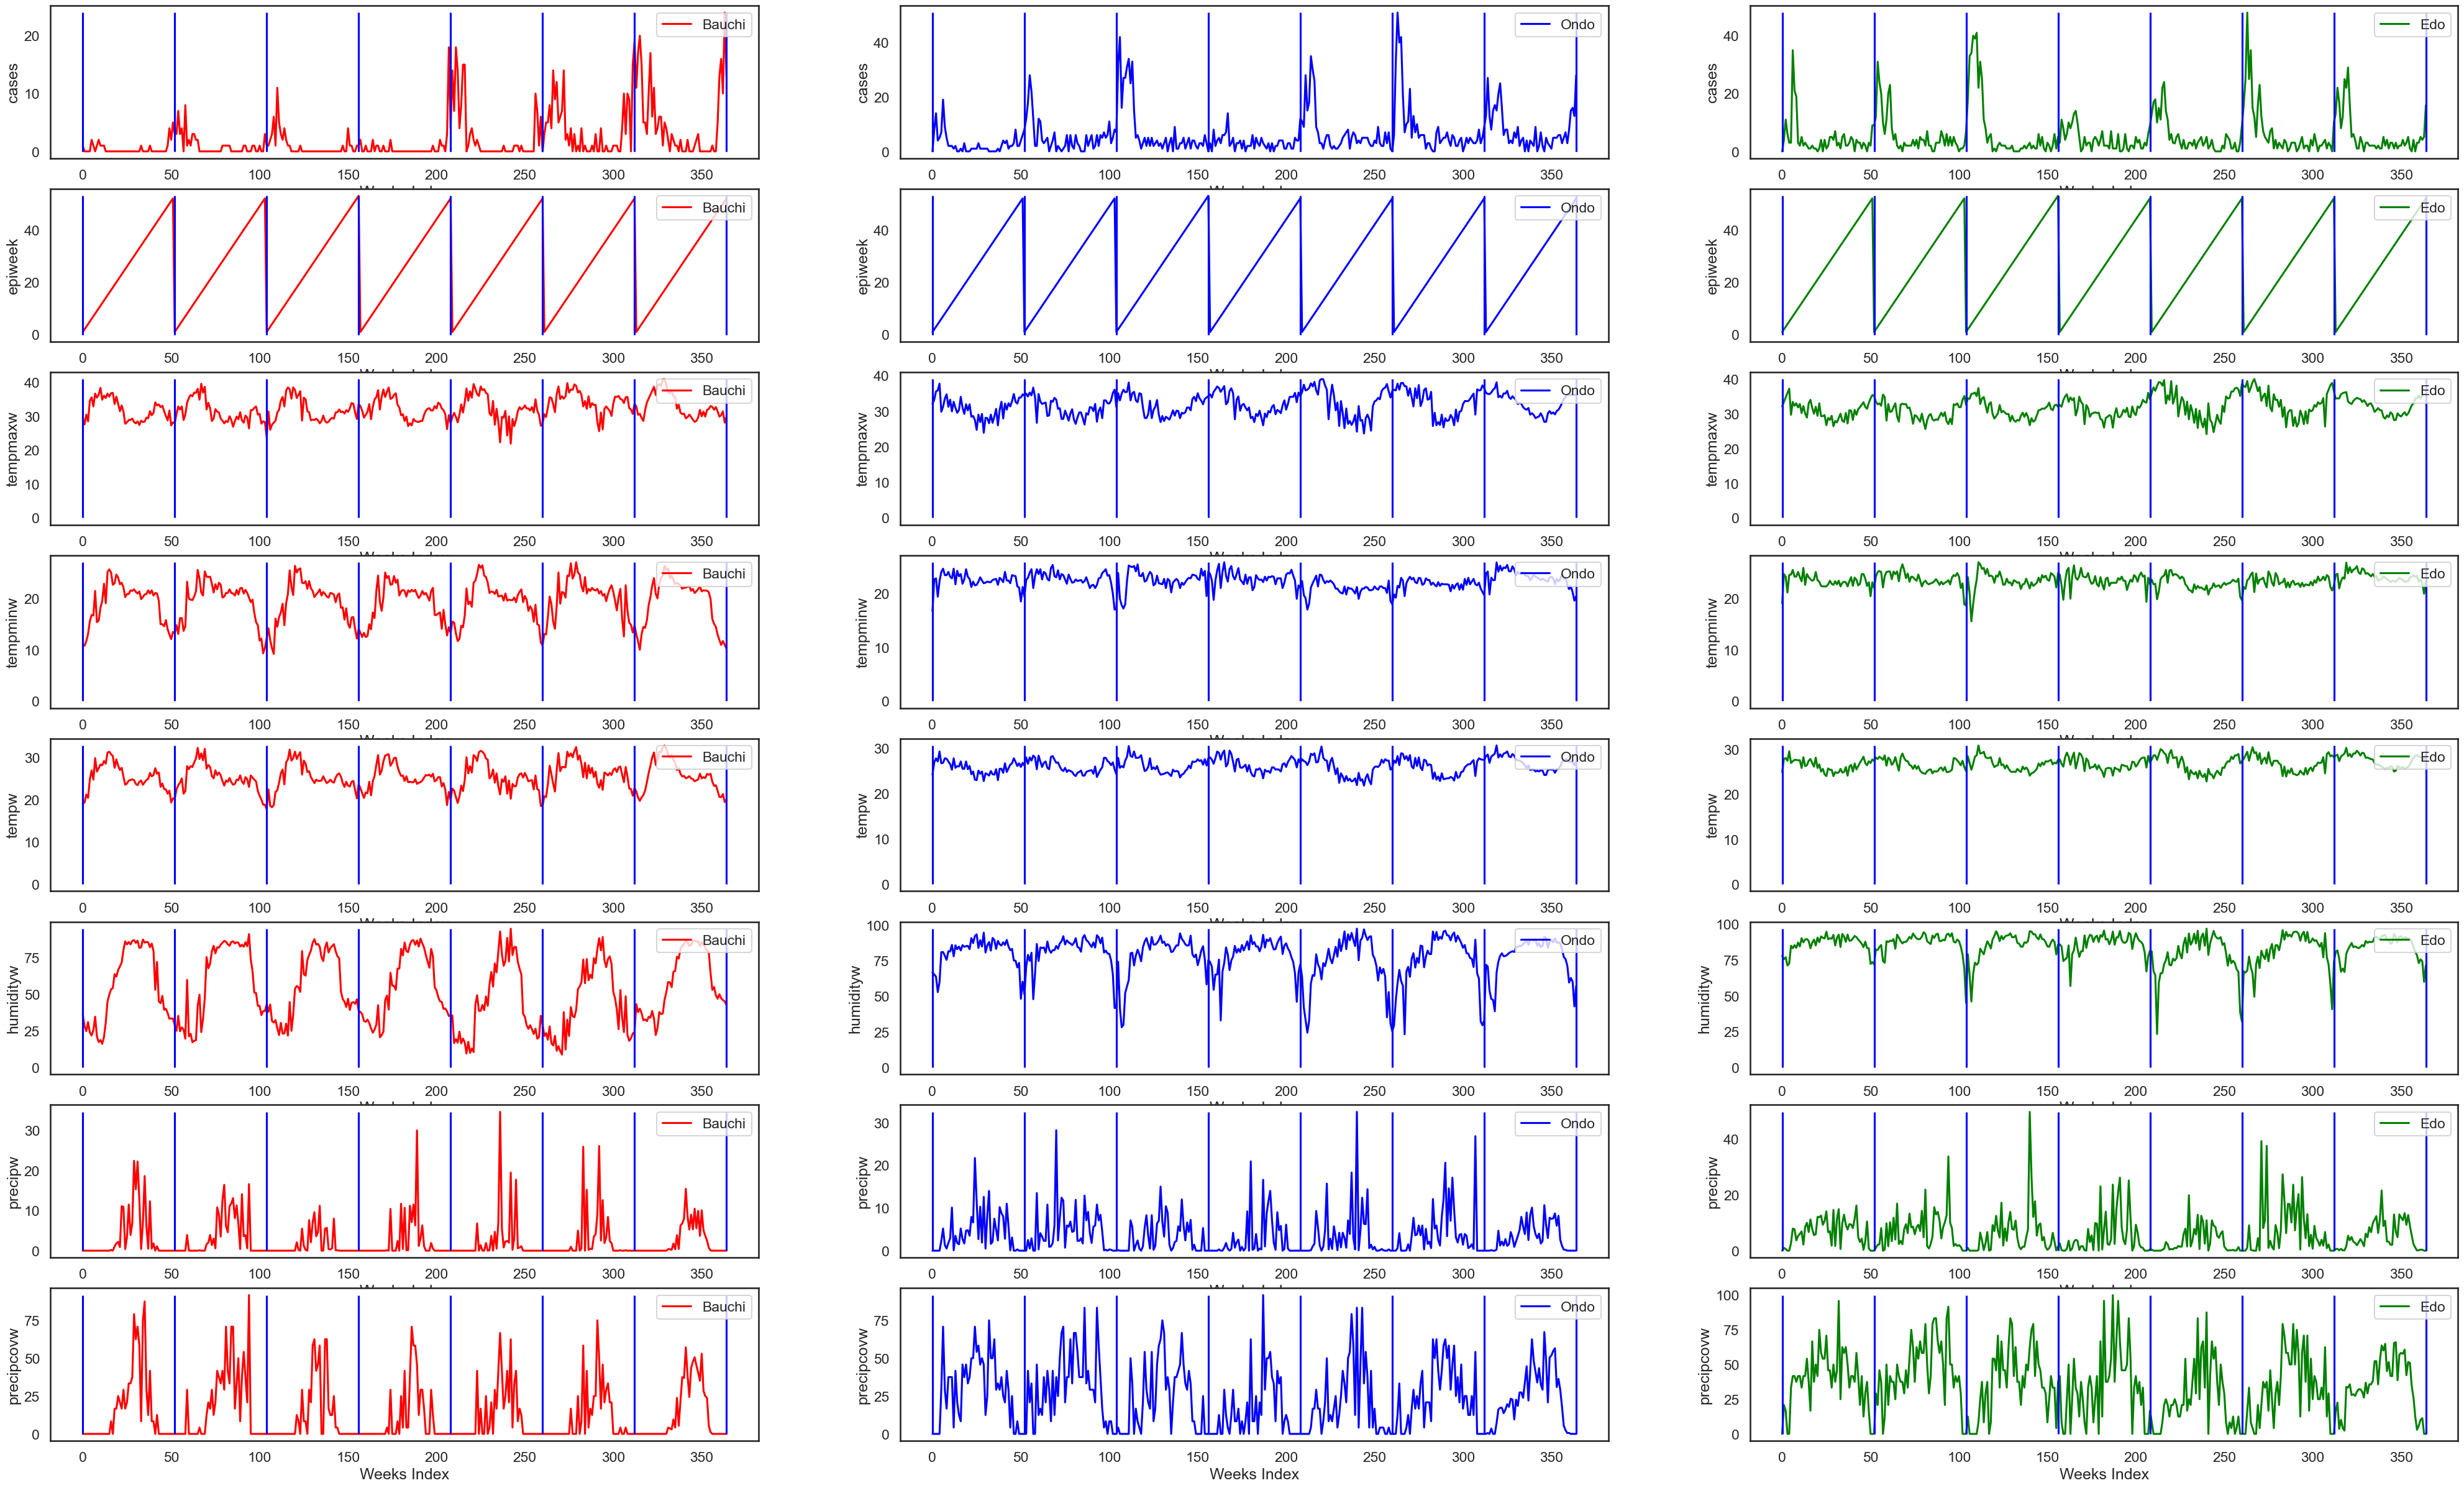

In [5]:
## visualize timeline by months
gp= df.sort_values(['state', 'year', 'epiweek']).groupby('state')
colours = ['red', 'blue', 'green']

vars= ['cases','epiweek', 'tempmaxw', 'tempminw', 'tempw', 'humidityw', 'precipw', 'precipcovw']
fig = plt.figure(constrained_layout=True, figsize=(50,30))
gs = gridspec.GridSpec(len(vars), 3, wspace=0.2, hspace=0.2, figure=fig)
for v_idx, var in enumerate(vars):
    for i, s in enumerate(['Bauchi', 'Ondo', 'Edo']):
        data = gp.get_group(s)
        ax = plt.subplot(gs[v_idx, i])
        ax.plot(np.arange(0, data[var].shape[0]), data[var], c=colours[i], label=s)
        ax.legend(loc="upper right")
        ax.set_xlabel('Weeks Index')
        ax.set_ylabel('%s'%var)
        for horiz in range(0, data.shape[0]+1, 52):
          ax.vlines(x = horiz, ymin=0, ymax=data[var].max(), color = 'b')
fig.tight_layout()
fig.savefig("data_by_state.png", dpi=300, bbox_inches='tight')
plt.show()

In [6]:
from ipywidgets import interact
@interact(var = ['cases','epiweek', 'tempmaxw', 'tempminw', 'tempw', 'humidityw', 'precipw', 'precipcovw'])
def vizualize(var):
    ## visualize timeline by months
    gp= df.sort_values(['state', 'year', 'epiweek']).groupby('state')
    colours = ['red', 'blue', 'green']
    fig, axs = plt.subplots(3, 1, figsize=(20,10))
    for i, s in enumerate(['Bauchi', 'Ondo', 'Edo']):
        data = gp.get_group(s)
        axs[i].plot(np.arange(0, data[var].shape[0]), data[var], c=colours[i], label=s)
        axs[i].legend(loc="upper right")
        axs[i].set_xlabel('Weeks Index')
        axs[i].set_ylabel('case count')
        for horiz in range(0, data.shape[0]+1, 52):
            axs[i].vlines(x = horiz, ymin=0, ymax=data[var].max(), color = 'b')
            axs[i].text(horiz,data[var].max()//2,2018+horiz//52,rotation=90)
        axs[i].legend
    fig.suptitle('%s across time in weeks'%var, fontsize=30)
    fig.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='var', options=('cases', 'epiweek', 'tempmaxw', 'tempminw', 'tempw'…

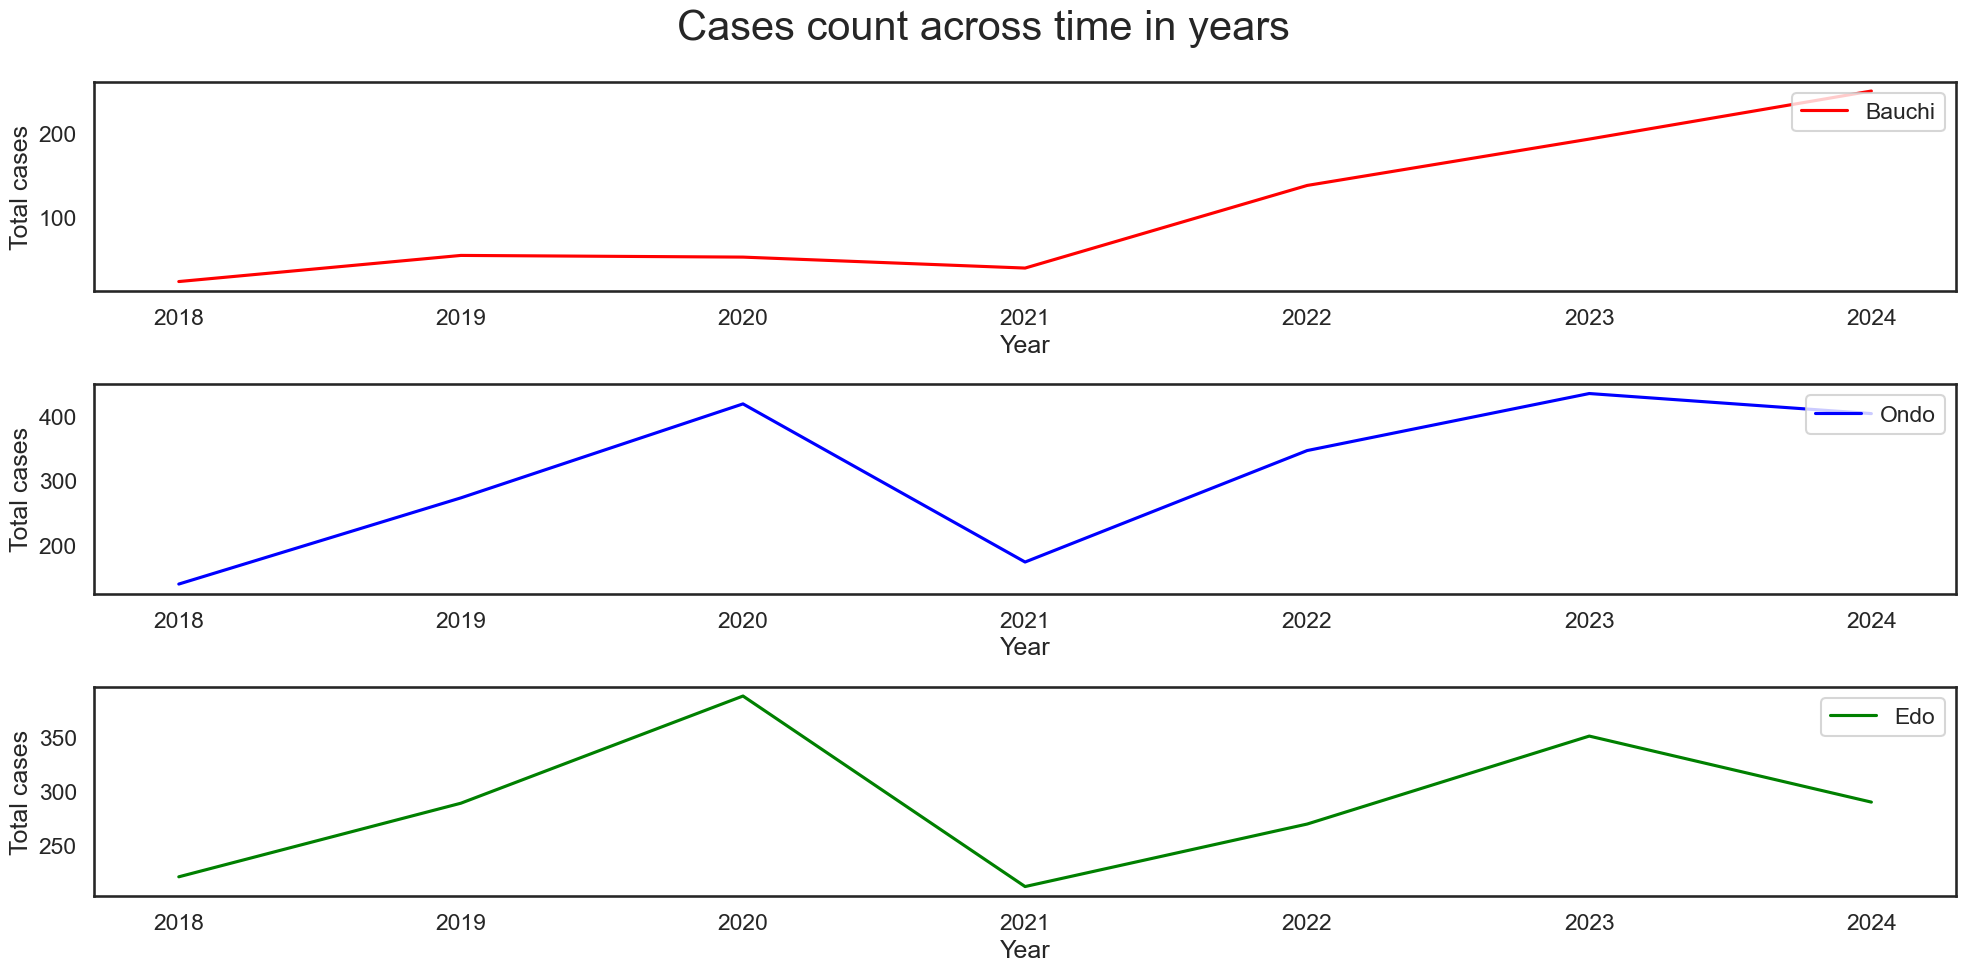

In [7]:
## visualize timeline by year
fig, axs = plt.subplots(3, 1, figsize=(20,10))
for i, s in enumerate(['Bauchi', 'Ondo', 'Edo']):
    data = gp.get_group(s).groupby(['year'])['cases'].agg(['sum'])
    axs[i].plot(data, c=colours[i], label=s)
    axs[i].legend(loc="upper right")
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Total cases')
fig.suptitle('Cases count across time in years', fontsize=30)
fig.tight_layout()
plt.show()

In [8]:
assert df.isnull().sum().sum() == 0
df.head()

,state,year,datetime,epiweek,cases,tempmaxw,tempminw,tempw,humidityw,precipw,precipcovw
0,Bauchi,2018,2018-01-07 00:00:00,1,1.0,29.5,10.8,19.0,36.1,0.0,0.0
1,Bauchi,2018,2018-01-14 00:00:00,2,0.0,27.6,10.8,19.3,28.1,0.0,0.0
2,Bauchi,2018,2018-01-21 00:00:00,3,0.0,30.5,11.7,21.2,24.8,0.0,0.0
3,Bauchi,2018,2018-01-28 00:00:00,4,0.0,28.5,13.1,20.4,30.9,0.0,0.0
4,Bauchi,2018,2018-02-04 00:00:00,5,0.0,34.6,15.6,24.8,23.8,0.0,0.0


In [9]:
# # Heat Map showing the correlation between all variables including the target
# investigative__col = ['month', 'tempmax', 'tempmin', 'temp', 'humidity', 'precip', 'precipcover', 'cases']
# investigative_data = df[investigative__col].copy()
# investigative_data
# corr=investigative_data.corr().abs()
# # fig, ax = plt.subplots(figsize=(16,16))
# matrix = np.triu(corr) # Getting the lower traingle of the correlation matrix
# sns.heatmap(matrix)
# # cbar_kws={"label": "Correlation", "shrink":1}
# # heatmap=sns.heatmap(data=corr, linewidths=1, square=False, cmap='Reds', ax=ax, annot=True,annot_kws={"size": 10}, mask=matrix, fmt= ".2f",cbar_kws=cbar_kws)
# # fig.suptitle('Heatmap of Correlation Between Data Features', fontsize=18, y=.94, x=.43)

In [10]:
# feature_columns = ['tempmaxw', 'tempminw', 'tempw', 'humidityw', 'precipw', 'precipcovw']
feature_columns = ['epiweek', 'tempmaxw', 'tempminw', 'tempw', 'humidityw', 'precipw', 'precipcovw']
target_column = ['cases']
feature_scaler = MinMaxScaler(feature_range=(0, 1))
label_scaler = MinMaxScaler(feature_range=(0, 1))
df[feature_columns] = feature_scaler.fit_transform(df[feature_columns].values)
df[target_column] = label_scaler.fit_transform(df[target_column].values)
df

,state,year,datetime,epiweek,cases,tempmaxw,tempminw,tempw,humidityw,precipw,precipcovw
0,Bauchi,2018,2018-01-07 00:00:00,0.000000,0.019608,0.397906,0.089385,0.086174,0.308126,0.000000,0.000000
1,Bauchi,2018,2018-01-14 00:00:00,0.019231,0.000000,0.298429,0.089385,0.106061,0.217833,0.000000,0.000000
2,Bauchi,2018,2018-01-21 00:00:00,0.038462,0.000000,0.450262,0.139665,0.232008,0.180587,0.000000,0.000000
3,Bauchi,2018,2018-01-28 00:00:00,0.057692,0.000000,0.345550,0.217877,0.178977,0.249436,0.000000,0.000000
4,Bauchi,2018,2018-02-04 00:00:00,0.076923,0.000000,0.664921,0.357542,0.470644,0.169300,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
1090,Ondo,2024,Week1091,0.903846,0.156863,0.656694,0.648045,0.610795,0.573363,0.000287,0.005957
1091,Ondo,2024,Week1092,0.923077,0.294118,0.661182,0.677574,0.614583,0.609642,0.000000,0.000000
1092,Ondo,2024,Week1093,0.942308,0.313725,0.668661,0.616121,0.603220,0.579490,0.000000,0.000000
1093,Ondo,2024,Week1094,0.961538,0.254902,0.655198,0.528332,0.559659,0.383908,0.000000,0.000000


In [11]:
df.describe()

,year,epiweek,cases,tempmaxw,tempminw,tempw,humidityw,precipw,precipcovw
count,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000
mean,2020.997260,0.491781,0.088849,0.526607,0.699307,0.551865,0.709279,0.081150,0.239928
std,1.998855,0.289587,0.134440,0.174384,0.173470,0.154009,0.247643,0.116499,0.234723
min,2018.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2019.000000,0.250000,0.019608,0.387435,0.659218,0.464015,0.598758,0.000000,0.000000
50%,2021.000000,0.500000,0.039216,0.523560,0.743017,0.550189,0.817156,0.032129,0.208300
75%,2023.000000,0.750000,0.098039,0.655572,0.804469,0.656250,0.887294,0.126506,0.416700
max,2024.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
class EpidemiologyModel(nn.Module):
    def __init__(self, feature_dim=8, hidden_size=128, num_lstm_layers = 2, bidirection=False, device='cpu'):
        super().__init__()
        self.device = device
        self.bidirection = bidirection
        self.hidden_size = hidden_size
        self.num_lstm_layers = num_lstm_layers
        self.lstm = nn.LSTM(input_size=feature_dim, hidden_size=self.hidden_size, dropout=0.3, bidirectional=self.bidirection, num_layers=self.num_lstm_layers, batch_first=True, device=self.device)
        if bidirection:
            self.regressor = nn.Linear(2*self.hidden_size, 1, device= self.device)
        else:
            self.regressor = nn.Linear(self.hidden_size, 1, device= self.device)
    def forward(self, x):
        self.lstm.flatten_parameters()
        if self.bidirection:
            h_0 = Variable(torch.zeros(2*self.num_lstm_layers, x.size(0), self.hidden_size, device= self.device)) #hidden state
            c_0 = Variable(torch.zeros(2*self.num_lstm_layers, x.size(0), self.hidden_size, device = self.device)) #internal state
        else:
            h_0 = Variable(torch.zeros(self.num_lstm_layers, x.size(0), self.hidden_size, device = self.device)) #hidden state
            c_0 = Variable(torch.zeros(self.num_lstm_layers, x.size(0), self.hidden_size, device= self.device)) #internal state

        out, (h_n, c_o) = self.lstm(x, (h_0, c_0))
        x = self.regressor(out[:,-1, :])
        return x

class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if abs(validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True


In [13]:
def create_dataset(dataset, features_column, target_column, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(dataset.shape[0]-lookback):
        feature = dataset[features_column].iloc[i:i+lookback].values
        target = dataset[target_column].iloc[i+1:i+lookback+1].values
        X.append(feature)
        y.append(target)
    return torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.float)

In [14]:
def train(df, train_val_years, feature_columns, target_column
          , lstm_hidden_size=100, n_lstm_layers=2,
          lookback = 6, n_epochs = 2000, bidirection=False,
          enable_early_Stop =True, early_stop_tolerance = 5, min_delta=10,  state_filter='Bauchi'):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


    early_stopping = EarlyStopping(tolerance=early_stop_tolerance, min_delta=min_delta)
    data = df[df['state']==state_filter]

    model = EpidemiologyModel(feature_dim=len(feature_columns), hidden_size=lstm_hidden_size, num_lstm_layers=n_lstm_layers, device=device)
    model = model.to(device)


    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()

    data.index = data.datetime
    # data.drop(columns=['state', 'year' ,'datetime', 'epiweek'], inplace=True)
    data.drop(columns=['state', 'year' ,'datetime'], inplace=True)


    X, y = create_dataset(data, feature_columns, target_column, lookback)

    X = X.to(device)
    y = y.to(device)


    train_len = int(X.shape[0]*0.80)
    X_train, y_train, X_val, y_val = X[:train_len], y[:train_len], X[train_len:], y[train_len:]

    loader = DataLoader(TensorDataset(X_train, y_train), shuffle=False, batch_size=8)

    early_stopping = EarlyStopping(tolerance=early_stop_tolerance, min_delta=min_delta)
    train_log = []
    val_log = []
    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch[:, -1, :])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            model.eval()
            y_pred = model(X_train)
            train_rmse = np.sqrt(loss_fn(y_pred, y_train[:, -1, :]).cpu().item())
            train_log.append(train_rmse)

            y_pred = model(X_val)
            val_rmse = np.sqrt(loss_fn(y_pred, y_val[:, -1, :]).cpu().item())
            val_log.append(val_rmse)
            early_stopping(train_rmse, val_rmse)
            if early_stopping.early_stop and enable_early_Stop:
                print("We stopped at epoch:", epoch)
                break
            if (epoch+1) % 10 == 0:
                print("Epoch %d: train MSE %.4f, val MSE %.4f" % (epoch, train_rmse, val_rmse))

    fig= plt.figure(figsize=(20,10))
    plt.plot(np.array(train_log), c ='red')
    plt.plot(np.array(val_log), c ='green')
    plt.xlabel("Epochs")
    plt.ylabel("MSE")

    plt.title('Training and Validation Performance for {} state'.format(state_filter), fontsize=20)
    plt.tight_layout()
    plt.show()
    return model

In [15]:
def test_visualization(data, feature_columns, target_column, model, test_years, scaler, state_filter='Bauchi'):
    mae = metrics.MeanAbsoluteError()
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    data = df[df['state']==state_filter]
    data = data[data['year'].isin(test_years)].copy()
    data.sort_values(['year', 'epiweek'], inplace=True)
    data.sort_values(['year', 'epiweek'], inplace=True)

    test_gp = data.groupby(['state'])
    for i, s in enumerate([state_filter]):
        state_data = test_gp.get_group(s)
        fig, axs = plt.subplots(2, 3, figsize=(20,10))
        for j, ys in enumerate(test_years):
            state_data_year = state_data[state_data['year']== ys]
            state_data_year.drop(columns=['state', 'year', 'datetime'], inplace=True)
            X_test, y_test = create_dataset(state_data_year, feature_columns, target_column, 1)

            X_test, y_test = X_test.to(device), y_test.to(device)

            with torch.no_grad():
              model.eval()
              y_pred = model(X_test)
              err= mae(y_pred, y_test[:, -1, :]).item()
              y_pred = scaler.inverse_transform(y_pred.cpu().numpy())
              y_test = scaler.inverse_transform(y_test.cpu().numpy()[:, -1, :])

            #
           # plot
            axs[j//3, j%3].title.set_text(str(ys)+", Mean Absolute error (MAE): %.2f"%(err))
            axs[j//3, j%3].plot(y_pred, label='pred_y')
            axs[j//3, j%3].plot(y_test, label='true_y')
            axs[j//3, j%3].legend(loc="upper right")
            axs[j//3, j%3].set_xlabel('Week Index')
            axs[j//3, j%3].set_ylabel('Number of cases')

        fig.suptitle('Predictions for {} state'.format(s), fontsize=20)
        plt.tight_layout()

c:\Users\Yaknan\Documents\Academics\Rebekah's Thesis\code from Charles\lassa_fever_prediction_with_climate_data\.venv_lassa\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
C:\Users\Yaknan\AppData\Local\Temp\ipykernel_25072\61838174.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=['state', 'year' ,'datetime'], inplace=True)
C:\Users\Yaknan\AppData\Local\Temp\ipykernel_25072\3651532566.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internal

Epoch 9: train MSE 0.0528, val MSE 0.1198
Epoch 19: train MSE 0.0510, val MSE 0.1164
Epoch 29: train MSE 0.0504, val MSE 0.1165
Epoch 39: train MSE 0.0499, val MSE 0.1170
Epoch 49: train MSE 0.0495, val MSE 0.1177
Epoch 59: train MSE 0.0492, val MSE 0.1185
Epoch 69: train MSE 0.0488, val MSE 0.1193
Epoch 79: train MSE 0.0485, val MSE 0.1201
Epoch 89: train MSE 0.0481, val MSE 0.1210
Epoch 99: train MSE 0.0478, val MSE 0.1218
Epoch 109: train MSE 0.0475, val MSE 0.1226
Epoch 119: train MSE 0.0473, val MSE 0.1233
Epoch 129: train MSE 0.0470, val MSE 0.1240
Epoch 139: train MSE 0.0467, val MSE 0.1247
Epoch 149: train MSE 0.0465, val MSE 0.1253
Epoch 159: train MSE 0.0462, val MSE 0.1258
Epoch 169: train MSE 0.0460, val MSE 0.1263
Epoch 179: train MSE 0.0457, val MSE 0.1268
Epoch 189: train MSE 0.0455, val MSE 0.1272
Epoch 199: train MSE 0.0453, val MSE 0.1276
Epoch 209: train MSE 0.0450, val MSE 0.1280
Epoch 219: train MSE 0.0448, val MSE 0.1283
Epoch 229: train MSE 0.0446, val MSE 0.1286

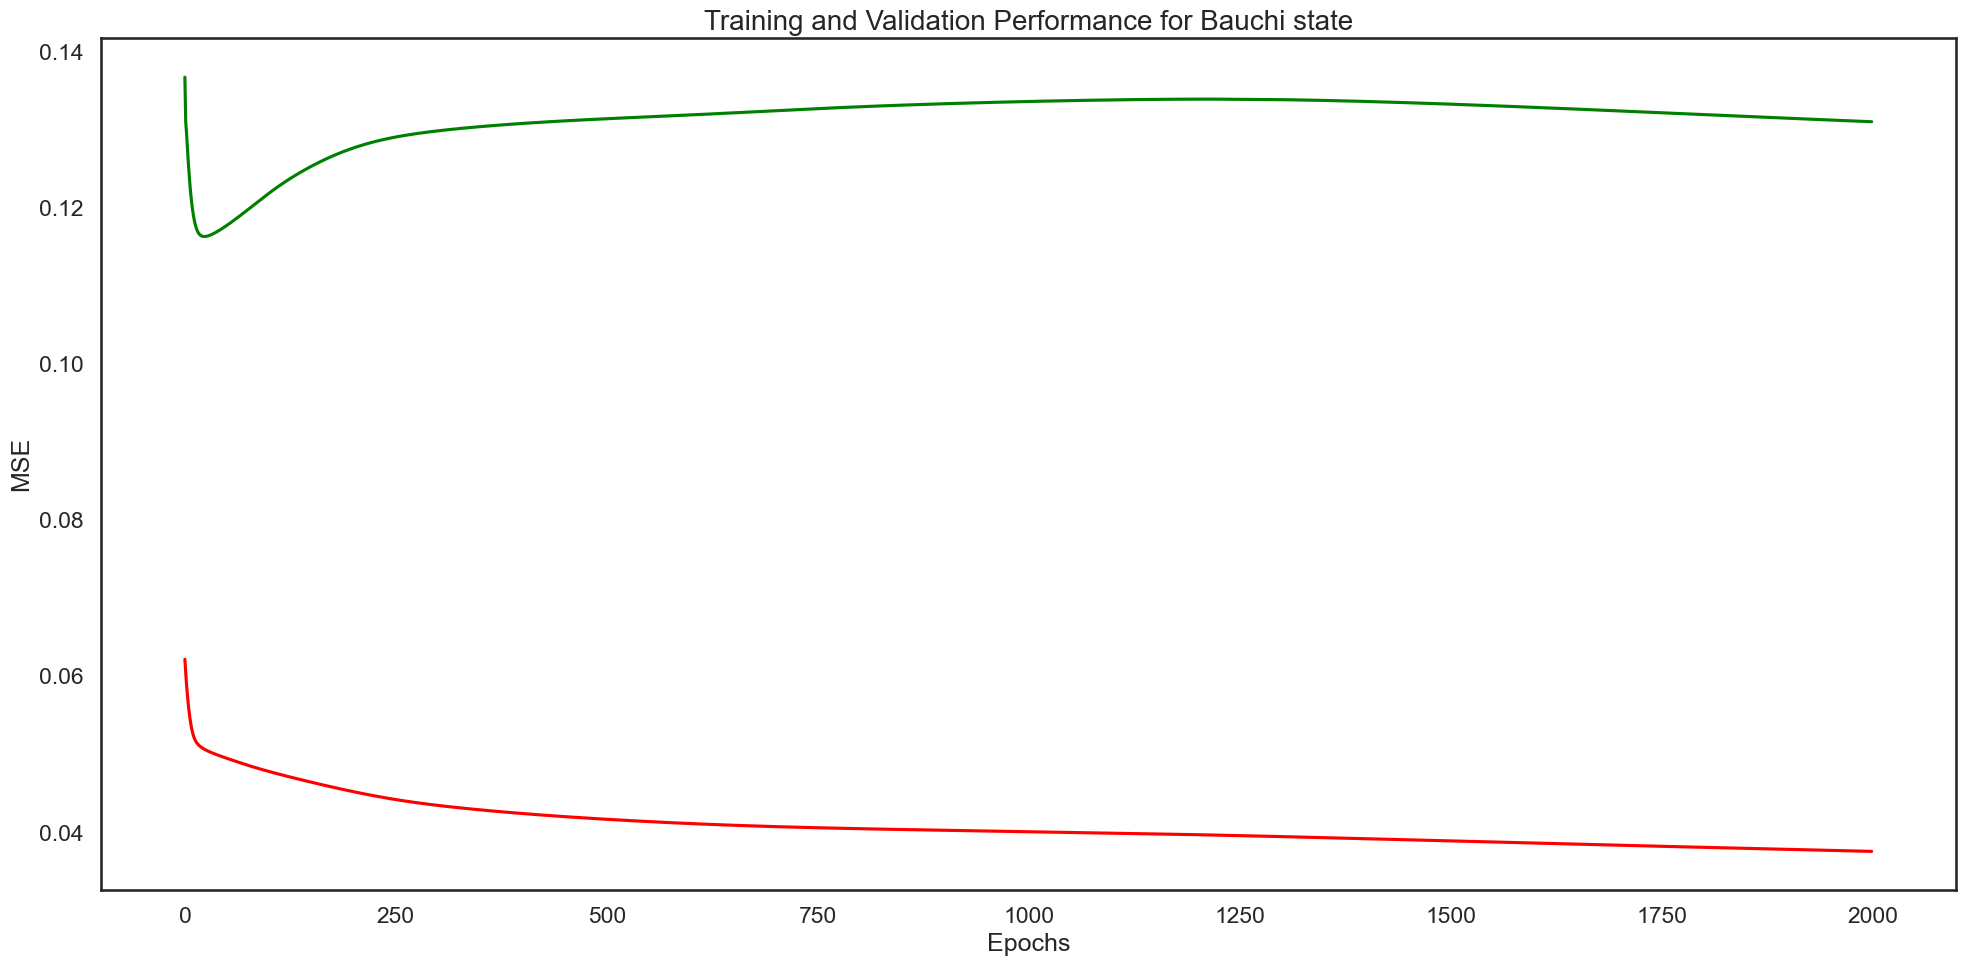

C:\Users\Yaknan\AppData\Local\Temp\ipykernel_25072\949601271.py:11: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  state_data = test_gp.get_group(s)
C:\Users\Yaknan\AppData\Local\Temp\ipykernel_25072\949601271.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_data_year.drop(columns=['state', 'year', 'datetime'], inplace=True)
C:\Users\Yaknan\AppData\Local\Temp\ipykernel_25072\949601271.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_data_year.drop(co

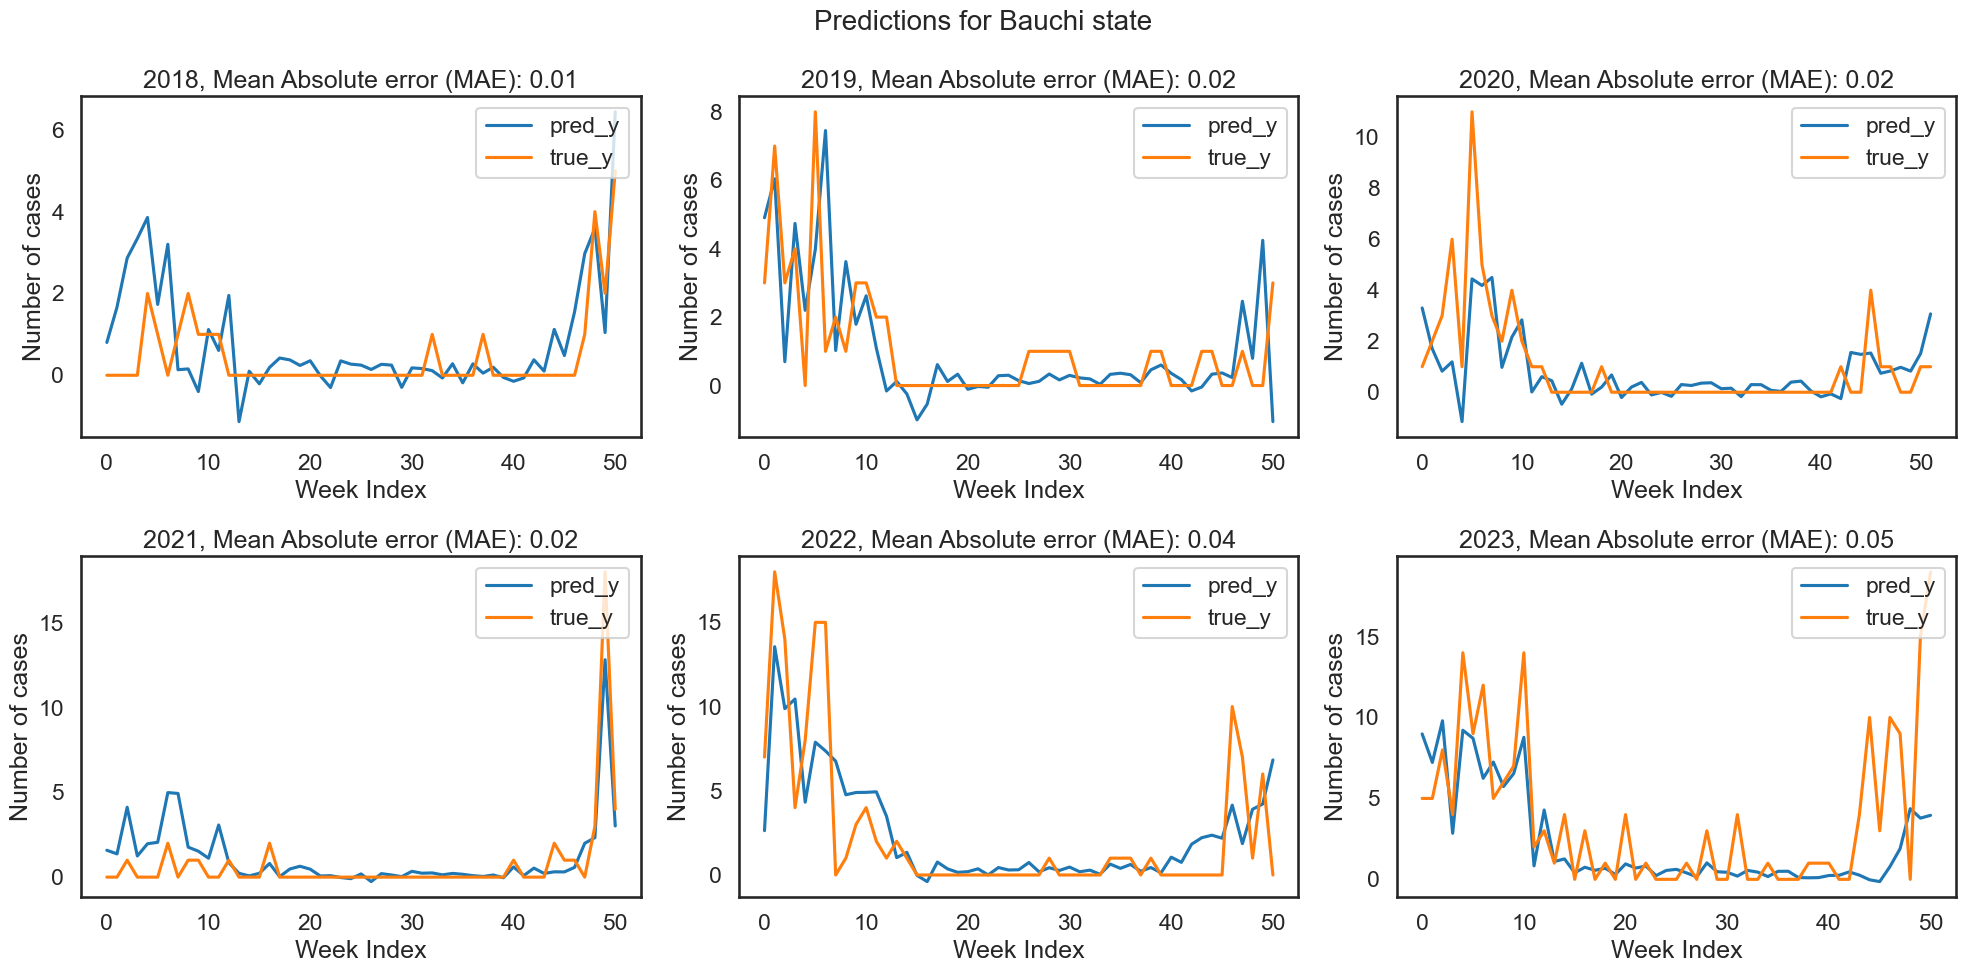

In [16]:
# Define the years for training and testing data
train_val_years = [2018, 2019, 2020, 2021, 2022]  # Years for training data
test_years = [2018, 2019, 2020, 2021, 2022, 2023]  # test behavior of all years including 2023

epidemiology_model = train(df, train_val_years, feature_columns, target_column, lstm_hidden_size=20, n_lstm_layers=1, lookback = 1,
                           n_epochs = 2000, enable_early_Stop = False, early_stop_tolerance = 5, min_delta=5, bidirection=True, state_filter='Bauchi')

test_visualization(df, feature_columns, target_column, epidemiology_model, test_years, label_scaler, state_filter='Bauchi')